In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import torch
import torch.nn as nn

https://www.kaggle.com/c/digit-recognizer

In [2]:
train = pd.read_csv('https://dl.uploadgram.me/6171ac48b6053h?raw')

In [3]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


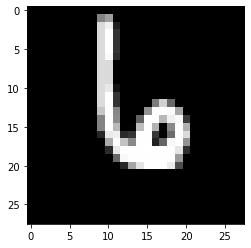

In [5]:
pixels = np.array(train.iloc[123])
pixels = pixels[1:]
pixels = pixels.reshape((28,28))

plt.imshow(pixels, cmap='gray');

In [6]:
X_train = np.array(train.drop('label', 1)) / 255
y_train = np.array(train['label'])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)
print('X_test.shape', X_test.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


X_train.shape (33600, 784)
y_train.shape (33600,)
X_test.shape (8400, 784)


In [7]:
%%time
# Веса всех нейронов
x0 = np.random.normal(size=(784, 10)) / np.sqrt(784)
neurons = torch.tensor(x0, requires_grad=True)

# Конвертируем датасет в читаемый торчом формат
X = torch.tensor(X_train)
y = torch.tensor(y_train)
# SGD
optimizer = torch.optim.SGD(params=[neurons], lr=1)

loss_history = []

# 100 шагов
for i in range(100):
    # считаем произведение матрицы параметров на матрицу (из 10 нейронов) весов
    predictions = X @ neurons
    # Вычисляем loss
    loss = torch.nn.functional.cross_entropy(predictions, y) # функция активации уже включена
    # Вычисляем градиент
    optimizer.zero_grad()
    loss.backward()
    # Делаем шаг
    optimizer.step()
    # логируем loss
    loss_history.append(loss.data.numpy())

CPU times: user 9.83 s, sys: 11.5 ms, total: 9.84 s
Wall time: 9.92 s


Весь датасет прошли за 15 сек!

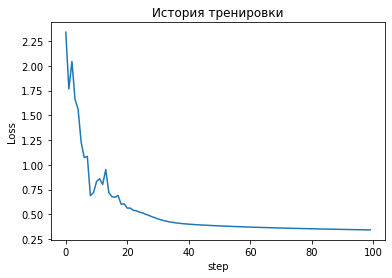

In [8]:
plt.title('История тренировки')
plt.ylabel('Loss')
plt.xlabel('step')
plt.plot(loss_history);

Посмотрим на нейроны

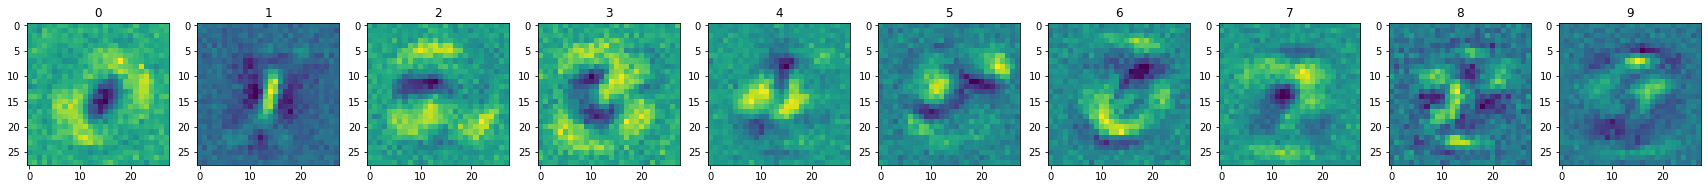

In [9]:
fig, axes = plt.subplots(1, 10, figsize=(30,30))

for i in range(10):
    axes[i].set_title(i)
    neuron_img = neurons[:,i].data.numpy().reshape(28, 28)
    axes[i].imshow(neuron_img)

Куда больше похоже на цифры по силуэтам!

In [10]:
# Тот же код для метрик качества
def sigmoid(x):
    ex = np.exp(x)
    return ex / (1 + ex)

digit_probabilities = sigmoid((X @ neurons).data.numpy())
print('digit_probabilities.shape:', digit_probabilities.shape)
# Находим вероятности на test

from sklearn.metrics import f1_score 

# Максимум
predictions = np.argmax(digit_probabilities, axis=1)
print('predictions.shape:', predictions.shape)
print('\nTrain f1:', f1_score(y_train, predictions, average='macro'))

digit_probabilities.shape: (33600, 10)
predictions.shape: (33600,)

Train f1: 0.9031460282614547


Стало 90%! Все из-за кол-ва данных, используем не 500 примеров, а все!

Пример на 10 нейронах

In [11]:
# Будет использовать высокоуровневый API torch: nn
# Когда мы создаем нейронную сеть в pytorch, мы обычно создаем класс, который происходит от torch.nn.Module
# Это легко обучить и в дальнейшем использовать сеть, определенную таким образом
# Эта сеть имеет 210 нейронов
import torch.nn.functional as F

class MyFirstNN(nn.Module):
    def __init__(self, n_hidden_neurons=200):
        super().__init__()
        # Здесь мы определяем обучаемые параметры модели
        # Первый слой весов
        # init_1 = np.random.normal(size=(784, n_hidden_neurons)) / np.sqrt(784) # гуглите "xavier initialization"
        # self.neurons_layer1 = torch.tensor(init_1, requires_grad=True) # веса для первого слоя нейронов
        # self.neurons_layer1 = nn.Parameter(self.neurons_layer1)
        self.neurons_layer1 = nn.Linear(784, n_hidden_neurons)

        # веса для второго слоя нейронов
        # init_2 = np.random.normal(size=(n_hidden_neurons, 10)) / np.sqrt(n_hidden_neurons)
        # self.neurons_layer2 = torch.tensor(init_2, requires_grad=True)
        # self.neurons_layer2 = nn.Parameter(self.neurons_layer2)
        self.neurons_layer2 = nn.Linear(n_hidden_neurons, 10)

    def forward(self, x):
        # Здесь мы делаем все вычисления
        # Первый слой
        # h = x @ self.neurons_layer1
        h = self.neurons_layer1(x)
        # Функция активации скрытого слоя
        # h = torch.relu(h)
        h = F.relu(h)

        # Выходной слой
        # out = h @ self.neurons_layer2
        out = self.neurons_layer2(h)
        return out

In [12]:
import numpy as np

model = MyFirstNN()
# инициализируем Adam для накопления импульса во время спуска
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [14]:
from tqdm import tqdm

N_EPOCHS = 50

# Конвертируем в торч тензор
X_tr = torch.tensor(X_train[1000:], dtype=torch.float32)
y_tr = torch.tensor(y_train[1000:], dtype=torch.long)
X_dev = torch.tensor(X_train[:1000], dtype=torch.float32)
y_dev = torch.tensor(y_train[:1000], dtype=torch.long)

train_loss_history = []
dev_loss_history = []

# Пройдемся 50 эпох
for i in tqdm(range(N_EPOCHS)):
    # Прямой проход (предсказания)
    predictions = model(X_tr)
    # Функция потерь
    loss = torch.nn.functional.cross_entropy(predictions, y_tr) # активация уже включена
    # Градиенты
    optimizer.zero_grad()
    loss.backward()
    # Шаг спуска
    optimizer.step()
    train_loss_history.append(loss.item())
    
    # Валидируемся
    if i % 10 == 0:
        predictions = model(X_dev)
        loss = torch.nn.functional.cross_entropy(predictions, y_dev)
        dev_loss_history.append(loss.item())

100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


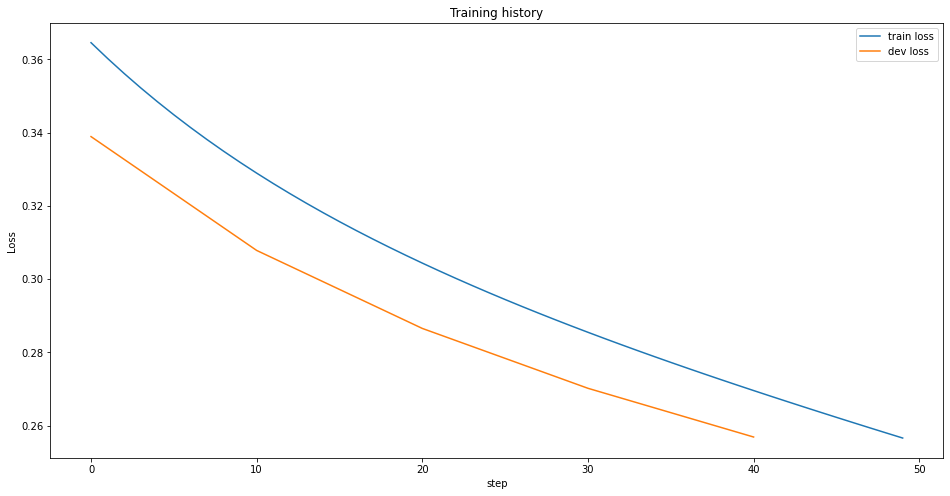

In [15]:
plt.figure(figsize=(16, 8))
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('step')
plt.plot(range(N_EPOCHS), train_loss_history, label='train loss')
plt.plot(range(N_EPOCHS)[::10], dev_loss_history, label='dev loss')
plt.legend();

In [16]:
# Метрики качества
digit_probabilities = model(X_dev).detach().numpy()
print('digit_probabilities.shape:', digit_probabilities.shape)
# Нашли вероятности принадлежности семплов test-а

from sklearn.metrics import classification_report

# Округлили
predictions = np.argmax(digit_probabilities, axis=1)
print('predictions.shape:', predictions.shape)
print('test results:') 
print(classification_report(y_dev.detach().cpu().numpy(), predictions))

digit_probabilities.shape: (1000, 10)
predictions.shape: (1000,)
test results:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95        86
           1       0.99      0.98      0.99       119
           2       0.93      0.93      0.93       103
           3       0.90      0.94      0.92        84
           4       0.93      0.94      0.93       109
           5       0.91      0.89      0.90        94
           6       0.96      0.98      0.97        92
           7       0.94      0.90      0.92       109
           8       0.93      0.88      0.90        96
           9       0.88      0.93      0.90       108

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [18]:
from torch.nn import ReLU
import torch.nn.functional as F

class MySecondNN(nn.Module):
    def __init__(self, n_hidden_neurons=200):
        # super позволяеть наследовать методы модуля nn 
        super(MySecondNN,self).__init__()
        # создаем линейный слой
        self.linear1 = nn.Linear(784,256)
        self.linear2 = nn.Linear(256,n_hidden_neurons)
        self.linear3 = nn.Linear(n_hidden_neurons,n_hidden_neurons)
        self.linear4 = nn.Linear(n_hidden_neurons,10)
        self.ReLU = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

import numpy as np

model = MySecondNN().cuda()
# инициализируем Adam для накопления импульса во время спуска
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [19]:
N_EPOCHS = 150

# Конвертируем в торч тензор
X_tr = torch.tensor(X_train[1000:], dtype=torch.float32).cuda()
y_tr = torch.tensor(y_train[1000:], dtype=torch.long).cuda()
X_dev = torch.tensor(X_train[:1000], dtype=torch.float32).cuda()
y_dev = torch.tensor(y_train[:1000], dtype=torch.long).cuda()

train_loss_history = []
dev_loss_history = []
ce = nn.CrossEntropyLoss()

# Пройдемся 501 эпоху 
for i in tqdm(range(N_EPOCHS)):
    # Прямой проход (предсказания)
    predictions = model(X_tr)
    # Функция потерь
    loss = ce(predictions, y_tr) # активация уже включена
    # Градиенты
    optimizer.zero_grad()
    loss.backward()
    # Шаг спуска
    optimizer.step()
    train_loss_history.append(loss.item())
    
    # Валидируемся
    if i % 10 == 0:
        predictions = model(X_dev)
        loss = ce(predictions, y_dev)
        dev_loss_history.append(loss.item())

100%|██████████| 150/150 [00:04<00:00, 30.78it/s]


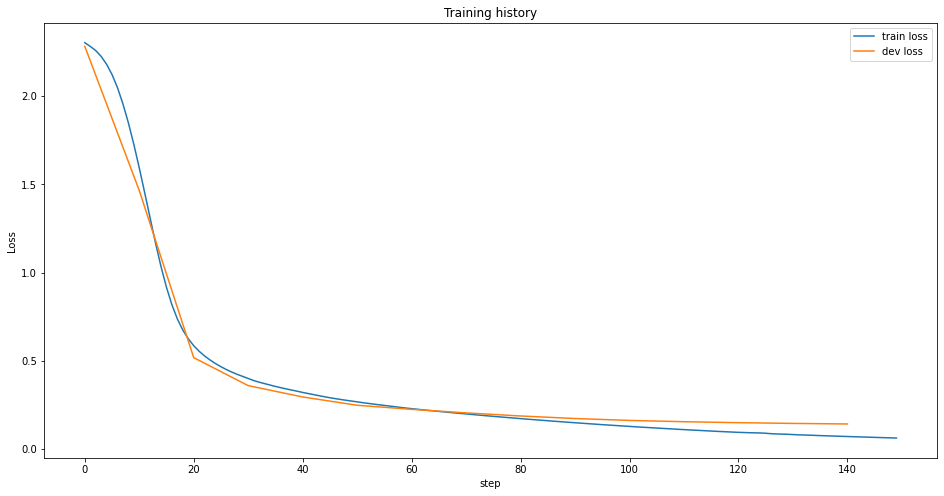

In [20]:
plt.figure(figsize=(16, 8))
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('step')
plt.plot(range(N_EPOCHS), train_loss_history, label='train loss')
plt.plot(range(N_EPOCHS)[::10], dev_loss_history, label='dev loss')
plt.legend();

# Классификация изображений

В этом практическом занятии мы будем решать задачу классификации картинок на 10 классов.

Мы будем работать с датасетом СIFAR10 и библиотекой PyTorch, которая создана специально для работы с нейронными сетями.

![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png)

In [21]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms
# метрика качества 
from sklearn.metrics import accuracy_score

In [22]:
# конвертируем сразу в pytorch tensor
transform_train = transforms.Compose([
    transforms.ToTensor()
])

transform_val = transforms.Compose([
    transforms.ToTensor()
])

In [23]:
# загрузим и сразу сконвертируем
train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_val)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [24]:
# загрузчики треин и тест части
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle = True, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle = False)

In [25]:
train_loader

In [26]:
dataiter = iter(train_loader)
# батч картинок и батч ответов к картинкам

images, labels = dataiter.next()

In [27]:
# размер датасета
images.shape, labels.shape

(torch.Size([16, 3, 32, 32]), torch.Size([16]))

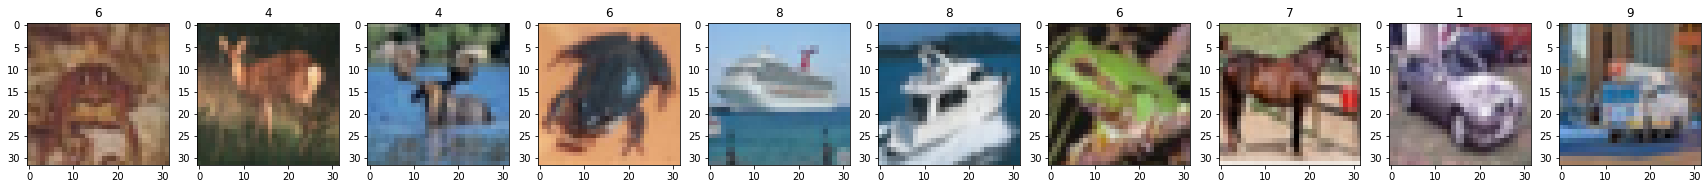

In [28]:
# отобразим несколько картинок
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
        # загружаем изображения как тип ndarray (Height * Width * Channels)
        # будьте внимательны при преобразовании dtype в np.uint8 [целое число (от 0 до 255)].
        # в этом примере я не использую метод ToTensor() из torchvision.transforms
        # поэтому вы можете преобразовать форму numpy ndarray в тензор в PyTorch (H, W, C) --> (C, H, W)
        axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
        axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)

Таблица соответствий номеров ответов и классов:


| Label        | Class           |
| ------------- |:-------------:|
| 0     | Самолет |
| 1    | Автомобиль      | 
| 2 | Птица      |
| 3 | Кошка      |
| 4 | Олень      |
| 5 | Собака      |
| 6 | Лягушка     |
| 7 | Лошадь     |
| 8 | Корабль     |
| 9 | Грузовик     |


Создадим словарь соответствий номера и названия, чтобы проще интерпретировать выход нейронной сети:

In [29]:
num_to_name = {
    0: "Самолет",
    1: "Автомобиль",
    2: "Птица",
    3: "Кошка",
    4: "Олень",
    5: "Собака",
    6: "Лягушка",
    7: "Лошадь",
    8: "Корабль",
    9: "Грузовик"
}


Импортируем нужные модули для обучения сети:

In [30]:
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активайии для слоев нейронных сетей
import torch.nn.functional as F

# Обучение и тест базовой сети

Для начала построим двуслойную полносвязную нейронную сеть, обучим ее и посчитаем метрику accuracy на тестовой выборке:

<a href="https://ibb.co/prDn4RG"><img src="https://i.ibb.co/G3wFCtB/Screen-Shot-2020-03-14-at-9-43-10-PM.png" alt="Screen-Shot-2020-03-14-at-9-43-10-PM" border="0"></a>

In [31]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        self.fc1 = nn.Linear(32*32*3, 256) # полносвязные слои - вход и выход
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.fc1(x))
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = self.fc2(x)
        return x

Давайте вынесем код обучения сети в отдельную функцию, чтобы каждый раз при изменении сети не копировать его. Код обучения мы менять не будем.

In [32]:
from tqdm.notebook import tqdm

In [33]:
def train(net, n_epoch=5):
    # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()

    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # acc по test
    best_accuracy = 0
    # обучаем сеть 2 эпохи
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            # так получаем текущий батч
            X_batch, y_batch = batch
            
            # обнуляем градиент
            optimizer.zero_grad()

            # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
            # bаckpropagation (вычисление градиентов)
            loss.backward()
            # обновление весов сети
            optimizer.step()
             
            # выведем текущий loss
            running_loss += loss.item()
            # выведем качество каждые 500 батчей
            if i % 500 == 499:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0          

        # менеджер упарвления контекстом торча указывает на то, чтобы не обновлять параметры
        with torch.no_grad():
            accuracy = []
            for batch in test_loader:
                x, y = batch
                y_pred = net(x)
                # loss = loss_fn(y_pred, y)
                # находим accuracy батча с теста
                accuracy.append(accuracy_score(y.detach().numpy(), np.argmax(y_pred.detach().numpy(), axis=1)))
            # усредняем accuracy всех батчей на тесте
            accuracy = np.mean(np.array(accuracy))
            # если стало лучше - сохраняем на диск и обновляем лучшую метрику
            if accuracy > best_accuracy:
                print('New best model with test acc:', accuracy)
                torch.save(net.state_dict(), './best_model.pt')
                best_accuracy = accuracy

    print('Обучение закончено')
    return net

In [19]:
# объявляем сеть
net = SimpleNet()
# теперь обучить сеть можно вызвав функцию train и передав туда переменную сети.
net = train(net)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

[1,   500] loss: 2.047
[1,  1000] loss: 1.890
[1,  1500] loss: 1.841
[1,  2000] loss: 1.795
[1,  2500] loss: 1.769
[1,  3000] loss: 1.760
New best model with test acc: 0.3959


  0%|          | 0/3125 [00:00<?, ?it/s]

[2,   500] loss: 1.736
[2,  1000] loss: 1.707
[2,  1500] loss: 1.707
[2,  2000] loss: 1.681
[2,  2500] loss: 1.690
[2,  3000] loss: 1.681
New best model with test acc: 0.4009


  0%|          | 0/3125 [00:00<?, ?it/s]

[3,   500] loss: 1.668
[3,  1000] loss: 1.651
[3,  1500] loss: 1.638
[3,  2000] loss: 1.629
[3,  2500] loss: 1.636
[3,  3000] loss: 1.648
New best model with test acc: 0.4212


  0%|          | 0/3125 [00:00<?, ?it/s]

[4,   500] loss: 1.618
[4,  1000] loss: 1.622
[4,  1500] loss: 1.611
[4,  2000] loss: 1.606
[4,  2500] loss: 1.612
[4,  3000] loss: 1.601
New best model with test acc: 0.4301


  0%|          | 0/3125 [00:00<?, ?it/s]

[5,   500] loss: 1.585
[5,  1000] loss: 1.570
[5,  1500] loss: 1.589
[5,  2000] loss: 1.598
[5,  2500] loss: 1.598
[5,  3000] loss: 1.580
New best model with test acc: 0.4424
Обучение закончено


In [20]:
# загрузка лучшей модели после
# model = SimpleNet()
# model.load_state_dict(torch.load('./best_model.pt'))
# model.eval()

Посчитаем accuracy на test:

In [21]:
with torch.no_grad():
    accuracy = []
    for batch in test_loader:
        x, y = batch
        y_pred = net(x)
        accuracy.append(accuracy_score(y.numpy(), np.argmax(y_pred.detach().numpy(), axis=1)))
    accuracy = np.mean(np.array(accuracy))

print('accuracy', accuracy)

accuracy 0.4424


# CUDA

In [34]:
device = torch.device('cuda')

In [35]:
torch.cuda.is_available()

True

In [36]:
torch.cuda.get_device_name()

'Tesla T4'

Все, что нам надо добавить - это .cuda() или .to(device), чтобы не только нейросеть была на видеокарте, но и обарбатываемые объекты были на видеопамяти

In [37]:
def train(net, n_epoch=10):
    # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()

    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # acc по test
    best_accuracy = 0
    # обучаем сеть 2 эпохи
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            # так получаем текущий батч
            X_batch, y_batch = batch
            # переносим его на видеопамять
            # если точно уверены, что это гпу - можно написать .cuda()
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # обнуляем веса
            optimizer.zero_grad()

            # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
            # bsckpropagation (вычисление градиентов)
            loss.backward()
            # обновление весов сети
            optimizer.step()

            # выведем текущий loss
            running_loss += loss.item()
            # выведем качество каждые 500 батчей
            if i % 500 == 499:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0

        # менеджер упарвления контекстом торча указывает на то, чтобы не обновлять параметры
        with torch.no_grad():
            accuracy = []
            for batch in test_loader:
                x, y = batch
                # переносим на гпу
                x = x.to(device)
                y = y.to(device)
                # прогнозируем
                y_pred = net(x)
                # loss = loss_fn(y_pred, y)
                # находим accuracy батча с теста
                accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
            # усредняем accuracy всех батчей на тесте
            accuracy = np.mean(np.array(accuracy))
            # если стало лучше - сохраняем на диск и обновляем лучшую метрику
            if accuracy > best_accuracy:
                print('New best model with test acc:', accuracy)
                torch.save(net.state_dict(), './best_model.pt')
                best_accuracy = accuracy

    print('Обучение закончено')
    return net

In [38]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(32*32*3, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
).to(device)

In [39]:
model = train(model, n_epoch=30)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

[1,   500] loss: 2.154
[1,  1000] loss: 2.082
[1,  1500] loss: 2.068
[1,  2000] loss: 2.063
[1,  2500] loss: 2.062
[1,  3000] loss: 2.042
New best model with test acc: 0.1933


  0%|          | 0/3125 [00:00<?, ?it/s]

[2,   500] loss: 2.013
[2,  1000] loss: 1.962
[2,  1500] loss: 1.917
[2,  2000] loss: 1.896
[2,  2500] loss: 1.892
[2,  3000] loss: 1.882
New best model with test acc: 0.2901


  0%|          | 0/3125 [00:00<?, ?it/s]

[3,   500] loss: 1.866
[3,  1000] loss: 1.854
[3,  1500] loss: 1.847
[3,  2000] loss: 1.821
[3,  2500] loss: 1.821


Exception in thread Thread-16:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 297, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/pytho

KeyboardInterrupt: ignored

In [41]:
with torch.no_grad():
    accuracy = []
    for batch in test_loader:
        x, y = batch
        y_pred = model(x.to(device))
        accuracy.append(accuracy_score(y.numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
    accuracy = np.mean(np.array(accuracy))

print('accuracy', accuracy)

accuracy 0.4506
